In [62]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

In [36]:
! ls ../data

LICENSE		  config_v2.0.json			    testing
README		  demo.py				    training
config_v1.2.json  mapillary-vistas-dataset_public_v2.0.zip  validation


In [3]:
data_dir = '../data/'

In [27]:
train_images_dir = os.path.join(data_dir, 'training/images')
train_labels_dir = os.path.join(data_dir, 'training/v2.0/labels')

In [63]:
train_image_files = os.listdir(train_images_dir)
train_label_files = os.listdir(train_labels_dir)

In [64]:
train_image_files[0], train_label_files[0]

('ooVVF3XDSAPcuqGc0UUq9A.jpg', 'ImkJ6D7d-uGne7mkqOQnSg.png')

In [35]:
'ooVVF3XDSAPcuqGc0UUq9A.png' in train_label_files

True

124


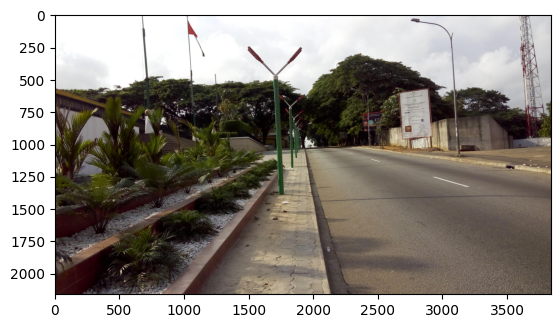

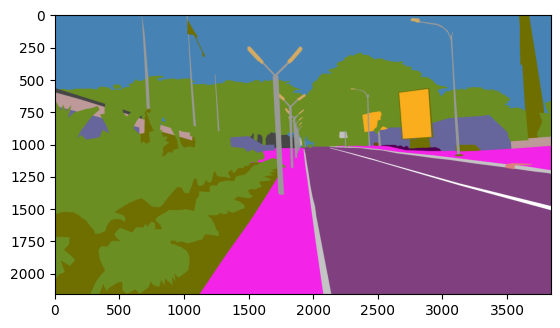

In [71]:
def apply_color_map(image_array, labels):
    color_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype=np.uint8)

    for label_id, label in enumerate(labels):
        # set all pixels with the current label to the color of the current label
        color_array[image_array == label_id] = label["color"]

    return color_array
    
def plot_img_label(image_id='M2kh294N9c72sICO990Uew'):
    # read in config file
    with open(os.path.join(data_dir, 'config_v2.0.json')) as config_file:
        config = json.load(config_file)
    # in this example we are only interested in the labels
    labels = config['labels']
    print(len(labels))
    # print labels
    # print("There are {} labels in the config file".format(len(labels)))
    # for label_id, label in enumerate(labels):
    #     print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))

    # set up paths for every image
    image_path = os.path.join(data_dir, "training/images/{}.jpg".format(image_id))
    label_path = os.path.join(data_dir, "training/v2.0/labels/{}.png".format(image_id))
    # instance_path = "training/{}/instances/{}.png".format(version, image_id)
    # panoptic_path = "training/{}/panoptic/{}.png".format(version, image_id)

    # load images
    base_image = Image.open(image_path)
    label_image = Image.open(label_path)
    # instance_image = Image.open(instance_path)
    # panoptic_image = Image.open(panoptic_path)

    # convert labeled data to numpy arrays for better handling
    label_array = np.array(label_image)
    # instance_array = np.array(instance_image, dtype=np.uint16)

    # now we split the instance_array into labels and instance ids
    # instance_label_array = np.array(instance_array / 256, dtype=np.uint8)
    # instance_ids_array = np.array(instance_array % 256, dtype=np.uint8)

    # for visualization, we apply the colors stored in the config
    # print(label_array)

    plt.imshow(base_image)
    plt.show()
    colored_label_array = apply_color_map(label_array, labels)
    plt.imshow(colored_label_array)
    plt.show()


image_fn = random.choice(train_image_files)
plot_img_label(os.path.splitext(image_fn)[0])